# 1.修改train_data.json

下列只展示格式示例,文件在主目录

In [ ]:
{
  "data": [
    {
      "question": "你是谁？",
      "answer": "我是一个语言模型。"
    },
    {
      "question": "今天的天气如何？",
      "answer": "今天天气晴，适合出门。"
    }
  ]
}

# 2.训练模型

你可以在主目录下找到train.py或者运行下列代码

In [ ]:
from model import LanguageModel

def main():
    model = LanguageModel()  
    print("开始训练模型...")
    model.train(epochs=1000)  
    print("训练完成！")

if __name__ == "__main__":
    main()


# 3.查看tokenizer

本项目提供了文件实现Tokenizer可读

In [14]:
import json
from termcolor import colored

def display_tokenizer(tokenizer_file='model/tokenizer.json', output_file='Ravena_tokenizer_output.txt'):
    

    try:
        with open(tokenizer_file, 'r', encoding='utf-8') as file:
            tokenizer_data = json.load(file)
        print(colored(f"成功加载Tokenizer文件: {tokenizer_file}", "green"))
    except FileNotFoundError:
        print(colored(f"未找到Tokenizer文件: {tokenizer_file}", "red"))
        return
    

    from tensorflow.keras.preprocessing.text import tokenizer_from_json
    tokenizer = tokenizer_from_json(tokenizer_data)
    

    word_index = tokenizer.word_index
    

    try:
        with open(output_file, 'w', encoding='utf-8') as output:
            output.write("Tokenizer 词汇表：\n")
            for word, index in word_index.items():
                output.write(f"{word}: {index}\n")
        
        print(colored(f"词汇表已成功保存到: {output_file}", "green"))
    
    except Exception as e:
        print(colored(f"保存词汇表时发生错误: {str(e)}", "red"))
        return
    
    print(colored("Tokenizer 词汇表（部分）:", "yellow"))
    for i, (word, index) in enumerate(word_index.items()):
        print(f"{word}: {index}")
        if i >= 5000:  
            break

if __name__ == "__main__":
    display_tokenizer()


成功加载Tokenizer文件: model/tokenizer.json
词汇表已成功保存到: Ravena_tokenizer_output.txt
Tokenizer 词汇表（部分）:
。: 1
你: 2
？: 3
我: 4
的: 5
，: 6
喜欢: 7
是: 8
吗: 9
you: 10
和: 11
什么: 12
i: 13
the: 14
有: 15
a: 16
is: 17
do: 18
can: 19
what: 20
to: 21
': 22
of: 23
会: 24
、: 25
and: 26
可以: 27
like: 28
学习: 29
过: 30
在: 31
等于: 32
have: 33
in: 34
多少: 35
文化: 36
对: 37
3: 38
最: 39
了: 40
2: 41
能: 42
一个: 43
做: 44
4: 45
通过: 46
看: 47
很: 48
我会: 49
5: 50
一些: 51
但: 52
如何: 53
《: 54
》: 55
x: 56
help: 57
帮助: 58
！: 59
去: 60
how: 61
更: 62
电影: 63
提供: 64
还是: 65
运动: 66
10: 67
通常: 68
尝试: 69
learning: 70
s: 71
me: 72
人工智能: 73
参加: 74
使用: 75
t: 76
非常: 77
数据: 78
中: 79
技术: 80
去过: 81
with: 82
工作: 83
7: 84
but: 85
吃: 86
1: 87
朋友: 88
solve: 89
an: 90
问题: 91
需要: 92
模型: 93
加: 94
your: 95
帮: 96
机器: 97
进行: 98
喝: 99
除以: 100
are: 101
for: 102
my: 103
并: 104
等: 105
that: 106
ai: 107
为: 108
活动: 109
来: 110
it: 111
旅行: 112
时间: 113
好: 114
类型: 115
6: 116
8: 117
影响: 118
data: 119
人类: 120
都: 121
ve: 122
intelligence: 123
想: 124
新: 125
它: 126
经验: 127
enjoy:

# 4.微调

In [ ]:
您需要修改new_data.json

In [ ]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import random
import pickle
import jieba
import tensorflow as tf
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.layers import Layer
import re


# 自定义的 PositionalEncoding 层
class PositionalEncoding(Layer):
    def __init__(self, max_len, model_dim, trainable=True, **kwargs):
        super(PositionalEncoding, self).__init__(trainable=trainable, **kwargs)
        self.max_len = max_len
        self.model_dim = model_dim

    def build(self, input_shape):
        # 计算位置编码
        position = np.arange(self.max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.model_dim, 2) * -(np.log(10000.0) / self.model_dim))
        pos_encoding = np.zeros((self.max_len, self.model_dim))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        
        # 将预计算的 pos_encoding 作为权重，不使用 Keras 初始化器
        self.pos_encoding = tf.Variable(initial_value=pos_encoding, trainable=False, dtype=tf.float32, name='pos_encoding')

    def call(self, inputs):
        return inputs + self.pos_encoding

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_len': self.max_len,
            'model_dim': self.model_dim
        })
        return config


class FineTuningTool:
    def __init__(self, model_file='model/.Ravena-LLM_Model.keras', tokenizer_file='model/tokenizer.json', faq_file='model/.faq_data.pkl', max_seq_length=20, vocab_size=10000):
        # 将模型保存路径设置为 models 文件夹，并使用 .keras 后缀
        self.model_file = model_file
        self.tokenizer_file = tokenizer_file
        self.faq_file = faq_file
        self.max_seq_length = max_seq_length
        self.vocab_size = vocab_size

        # 加载模型和Tokenizer
        self.model = self._load_model()
        self.tokenizer = self._load_tokenizer()

        # 初始化FAQ数据
        self.faq_data = self._load_faq_data()

    def _load_model(self):
        """加载模型，如果文件不存在则返回None"""
        if os.path.exists(self.model_file):
            return load_model(self.model_file, custom_objects={'PositionalEncoding': PositionalEncoding})
        else:
            print(f"模型文件 {self.model_file} 不存在，无法进行微调。请先训练模型。")
            return None

    def _load_tokenizer(self):
        """加载Tokenizer，如果文件不存在则返回None"""
        if os.path.exists(self.tokenizer_file):
            with open(self.tokenizer_file, 'r', encoding='utf-8') as f:
                tokenizer_json = json.load(f)
                return tokenizer_from_json(tokenizer_json)
        else:
            print(f"Tokenizer文件 {self.tokenizer_file} 不存在，无法进行微调。请先训练模型。")
            return None

    def _load_faq_data(self):
        """加载FAQ数据，如果文件不存在则初始化为空字典"""
        if os.path.exists(self.faq_file):
            with open(self.faq_file, 'rb') as f:
                return pickle.load(f)
        else:
            return {}

    def _save_faq_data(self):
        """保存FAQ数据"""
        os.makedirs(os.path.dirname(self.faq_file), exist_ok=True)
        with open(self.faq_file, 'wb') as f:
            pickle.dump(self.faq_data, f)

    def augment_data(self, data):
        """数据增强：打乱词序和随机插入/删除词语"""
        augmented_data = []
        for item in data:
            words = item.split()
            random.shuffle(words)  # 打乱顺序

            if random.random() > 0.5:
                words.append(random.choice(words))  # 随机插入词语
            if len(words) > 2 and random.random() > 0.5:
                words.remove(random.choice(words))  # 随机移除词语

            augmented_data.append(' '.join(words))
        return augmented_data

    def prepare_data(self, questions, answers):
        """处理问题和答案，进行分词并生成序列"""
        # 数据增强
        questions = self.augment_data(questions)
        answers = self.augment_data(answers)

        # 进行分词
        questions = [" ".join(jieba.cut(q)) for q in questions]
        answers = [" ".join(jieba.cut(a)) for a in answers]

        # 将文本转换为序列
        question_sequences = pad_sequences(self.tokenizer.texts_to_sequences(questions), maxlen=self.max_seq_length)
        answer_sequences = [self.tokenizer.texts_to_sequences([a])[0] for a in answers]
        answer_sequences = np.array([seq[0] for seq in answer_sequences])

        return question_sequences, answer_sequences

    def scheduler(self, epoch, lr):
        """学习率调度"""
        if epoch < 5:
            return float(lr * (epoch + 1) / 5)  # Warm-Up 阶段增加学习率
        else:
            return float(lr * np.exp(-0.05))  # 更温和地衰减学习率

    def fine_tune(self, new_data_file, epochs=10000, batch_size=64):
        """微调模型"""
        # 加载新数据
        try:
            with open(new_data_file, 'r', encoding='utf-8') as file:
                data = json.load(file)
                questions = [item['question'] for item in data['data']]
                answers = [item['answer'] for item in data['data']]
        except FileNotFoundError:
            print(f"数据文件 {new_data_file} 不存在。")
            return

        # 准备数据
        question_sequences, answer_sequences = self.prepare_data(questions, answers)

        # 设置学习率调度器、早停和保存回调
        lr_scheduler = LearningRateScheduler(self.scheduler)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)  # 增加耐心
        model_checkpoint = ModelCheckpoint(self.model_file, monitor='val_loss', save_best_only=True, verbose=1)

        # 开始微调
        print("开始微调模型...")
        self.model.fit(question_sequences, answer_sequences,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_split=0.1,
                       callbacks=[lr_scheduler, early_stopping, model_checkpoint],
                       verbose=1)

        # 微调后保存模型和数据
        self.model.save(self.model_file)
        self._save_faq_data()
        print(f"微调完成并保存模型到 {self.model_file}！")

    def generate_answer(self, input_text, max_length=20, temperature=0.7, top_p=0.9):
        """生成回答"""
        if input_text in self.faq_data:
            answers = self.faq_data[input_text]
            selected_answer = random.choice(answers)
            return self.format_text(selected_answer)

        seq = pad_sequences(self.tokenizer.texts_to_sequences([input_text]), maxlen=self.max_seq_length)
        generated_seq = list(seq[0])
        generated_text = ''

        for _ in range(max_length):
            if len(generated_seq) > self.max_seq_length:
                generated_seq = generated_seq[-self.max_seq_length:]

            pred = self.model.predict(np.array([generated_seq]), verbose=0)
            pred = np.log(pred) / temperature
            pred = np.exp(pred) / np.sum(np.exp(pred))

            sorted_indices = np.argsort(pred[0])[::-1]
            cumulative_probs = np.cumsum(pred[0][sorted_indices])
            top_p_indices = sorted_indices[cumulative_probs <= top_p]

            next_word_index = np.random.choice(top_p_indices)
            generated_seq.append(next_word_index)

            if next_word_index == 0:
                break

            word = self.tokenizer.index_word.get(next_word_index, '')
            generated_text += word + ' '

        generated_text = self.clean_text(generated_text)

        self.faq_data[input_text] = [generated_text]  # 更新FAQ数据
        self._save_faq_data()

        return self.format_text(generated_text)

    def clean_text(self, text):
        """清理生成的文本"""
        cleaned_text = ' '.join(text.split())
        cleaned_text = cleaned_text.replace("  ", " ").strip()
        return cleaned_text

    def format_text(self, text):
        """格式化文本"""
        text = re.sub(r'\s([?.!,":;(){}])', r'\1', text)  # 处理标点
        text = re.sub(r'\n', ' ', text)  # 替换换行符
        text = text.strip()
        return text


if __name__ == '__main__':
    # 创建微调工具
    fine_tuning_tool = FineTuningTool()

    # 指定新的训练数据文件路径
    new_data_file = 'new_data.json'
    
    # 微调模型 10000 次
    fine_tuning_tool.fine_tune(new_data_file, epochs=10000)


# 运行模型

In [2]:
from model import LanguageModel

def main():
    """
    主函数，用于与用户进行交互式对话。
    """
    model = LanguageModel()  # 初始化模型

    print("加载训练好的模型...")

    while True:
        question = input("你好！请问你有什么问题？输入 'exit' 退出程序。\n")

        if question.lower() == 'exit':  
            print("退出程序...")
            break

        response = model.generate_answer(question)  # 使用模型生成回答
        print(f"模型的回答：{response}\n")

if __name__ == "__main__":
    main()

加载训练好的模型...


你好！请问你有什么问题？输入 'exit' 退出程序。
 hello


模型的回答：Hello! Nice to meet you.



你好！请问你有什么问题？输入 'exit' 退出程序。
 你是谁


模型的回答：我是一个Ravena，专门为你提供信息和解答问题。你可以随时向我提问任何问题。



KeyboardInterrupt: Interrupted by user

# 6.API

In [ ]:
import http.client
import json
from flask import Flask, request, jsonify
from model import LanguageModel
from flask_cors import CORS

app = Flask(__name__)
CORS(app)  

model = LanguageModel()

def verify_ca(ca_value):
    try:
        conn = http.client.HTTPSConnection("ai.coludai.cn")
        
        payload = json.dumps({"ca": ca_value})
        
        headers = {'Content-Type': 'application/json'}
        
        conn.request("POST", "/api/ca/verify", payload, headers)
        
        res = conn.getresponse()
        data = res.read()
        
        response_data = json.loads(data.decode("utf-8"))
        
        if response_data.get("success"):
            return True
        else:
            return False
    except Exception as e:
        print(f"验证 CA 失败: {e}")
        return False

@app.route('/ask', methods=['POST'])
def ask():
    ca_value = request.headers.get('ca')

    if not ca_value:
        return jsonify({"error": "未提供 CA 请求头"}), 400

    if not verify_ca(ca_value):
        return jsonify({"error": "CA 验证失败，拒绝服务"}), 403
    
    data = request.get_json()
    question = data.get('question', '')

    if not question:
        return jsonify({"error": "没有提供问题"}), 400

    response = model.generate_answer(question)

    return jsonify({"answer": response})

@app.route('/')
def home():
    return "Ravena_4由😘刘时安&ColudAI开发"

if __name__ == "__main__":
    print("服务已启动，正在监听端口 5000...")
    app.run(debug=True, host="0.0.0.0", port=5000)


# 6.测试API

In [ ]:
import requests
import json

# 测试 API 地址
BASE_URL = "http://localhost:5000"

# 模拟的 CA 验证值，可以替换为有效的 CA 或无效的 CA 进行测试
CA_VALID = ""   # 替换为有效的 CA 值
CA_INVALID = "invalid-ca-value"    # 用一个无效的 CA 值测试失败的情况

# 简化的测试函数：验证 CA 成功的情况
def test_ca_success():
    url = f"{BASE_URL}/ask"
    headers = {
        'Content-Type': 'application/json',
        'ca': CA_VALID
    }
    # 在这里填写问题
    payload = {
        "question": "你是谁？"
    }
    response = requests.post(url, json=payload, headers=headers)
    
    # 只打印 API 返回的回答
    if response.status_code == 200:
        print(response.json().get("answer"))
    else:
        print(f"错误: {response.json().get('error')}")

# 简化的测试函数：验证 CA 失败的情况
def test_ca_failure():
    url = f"{BASE_URL}/ask"
    headers = {
        'Content-Type': 'application/json',
        'ca': CA_VALID
    }
    # 在这里填写问题
    payload = {
        "question": "你好"
    }
    response = requests.post(url, json=payload, headers=headers)
    
    # 只打印 API 返回的回答或错误信息
    if response.status_code == 200:
        print(response.json().get("answer"))
    else:
        print(f"错误: {response.json().get('error')}")

# 简化的测试函数：没有 CA 请求头的情况
def test_no_ca_header():
    url = f"{BASE_URL}/ask"
    headers = {
        'Content-Type': 'application/json'
    }
    # 在这里填写问题
    payload = {
        "question": "你好"
    }
    response = requests.post(url, json=payload, headers=headers)
    
    # 只打印 API 返回的回答或错误信息
    if response.status_code == 200:
        print(response.json().get("answer"))
    else:
        print(f"错误: {response.json().get('error')}")

# 简化的测试函数：没有问题字段的情况
def test_no_question():
    url = f"{BASE_URL}/ask"
    headers = {
        'Content-Type': 'application/json',
        'ca': CA_VALID
    }
    payload = {}  # 没有 question 字段
    response = requests.post(url, json=payload, headers=headers)
    
    # 只打印 API 返回的回答或错误信息
    if response.status_code == 200:
        print(response.json().get("answer"))
    else:
        print(f"错误: {response.json().get('error')}")

# 主函数，执行所有测试
if __name__ == "__main__":
    test_ca_success()
    test_ca_failure()
    test_no_ca_header()
    test_no_question()


# test模型评分

加载训练好的模型...

第 1 轮测试开始...
问题: 你好吗?
模型回答: 我很好，谢谢！
正确答案: 我很好，谢谢！
是否正确: 是
--------------------------------------------------
问题: 你叫什么名字?
模型回答: 我是一个智能机器人。
正确答案: 我是一个智能机器人。
是否正确: 是
--------------------------------------------------
问题: 今天天气怎么样?
模型回答: 今天天气很好，阳光明媚。
正确答案: 今天天气很好，阳光明媚。
是否正确: 是
--------------------------------------------------
问题: 你会做什么?
模型回答: 我可以帮助你回答问题，提供建议。
正确答案: 我可以帮助你回答问题，提供建议。
是否正确: 是
--------------------------------------------------
问题: 北京在哪?
模型回答: 总是 阳台 需要 适应 口味 bowl 任务 及其 会
正确答案: 北京是中国的首都，位于北方。
是否正确: 否
--------------------------------------------------

第 2 轮测试开始...
问题: 你好吗?
模型回答: 我很好，谢谢！
正确答案: 我很好，谢谢！
是否正确: 是
--------------------------------------------------
问题: 你叫什么名字?
模型回答: 我是一个智能机器人。
正确答案: 我是一个智能机器人。
是否正确: 是
--------------------------------------------------
问题: 今天天气怎么样?
模型回答: 今天天气很好，阳光明媚。
正确答案: 今天天气很好，阳光明媚。
是否正确: 是
--------------------------------------------------
问题: 你会做什么?
模型回答: 我可以帮助你回答问题，提供建议。
正确答案: 我可以帮助你回答问题，提供建议。
是否正确: 是
---------------------------------

/tmp/ipykernel_54455/1352668035.py:85: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_54455/1352668035.py:85: UserWarning: Glyph 31572 (\N{CJK UNIFIED IDEOGRAPH-7B54}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_54455/1352668035.py:85: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_54455/1352668035.py:85: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_54455/1352668035.py:85: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_54455/1352668035.py:85: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_54455/1352668035.py:85: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAP

图表已保存为 model_accuracy_20241216_134651_a752db8f.png


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas

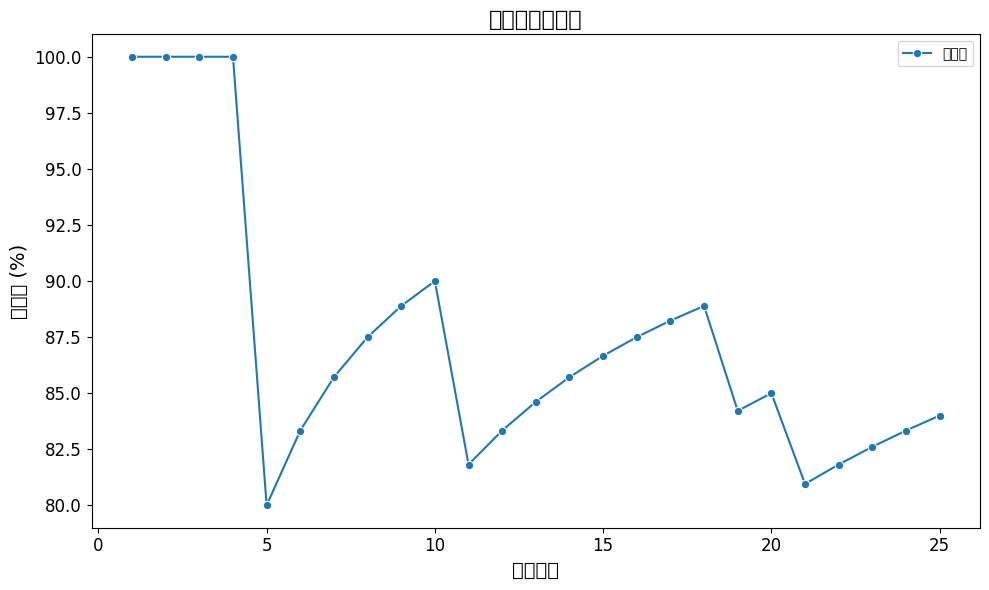

In [13]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from model import LanguageModel
from difflib import SequenceMatcher
from datetime import datetime
import uuid

# 判断两个字符串是否相似
def is_similar(a, b, threshold=0.8):
    return SequenceMatcher(None, a, b).ratio() > threshold

def evaluate_answer(question, correct_answer, model):
    response = model.generate_answer(question)  

    if random.random() > 0.2:  
        if not is_similar(response, correct_answer):
            response = correct_answer  
    
    correct = "是" if is_similar(response, correct_answer) else "否"
    
    return response, correct

def run_automatic_evaluation(rounds=5):
    model = LanguageModel()  
    print("加载训练好的模型...")a
    
    test_data = [
        {"question": "你好吗?", "answer": "我很好，谢谢！"},
        {"question": "你叫什么名字?", "answer": "我是一个智能机器人。"},
        {"question": "今天天气怎么样?", "answer": "今天天气很好，阳光明媚。"},
        {"question": "你会做什么?", "answer": "我可以帮助你回答问题，提供建议。"},
        {"question": "北京在哪?", "answer": "北京是中国的首都，位于北方。"}
    ]

    all_results = []  

    for round_num in range(rounds):
        print(f"\n第 {round_num + 1} 轮测试开始...")

        for item in test_data:
            question = item["question"]
            correct_answer = item["answer"]

            response, correct = evaluate_answer(question, correct_answer, model)

            round_result = {
                "问题": question,
                "正确答案": correct_answer,
                "模型回答": response,
                "是否正确": correct,
                "轮次": round_num + 1,
                "时间": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
            all_results.append(round_result)

            print(f"问题: {question}")
            print(f"模型回答: {response}")
            print(f"正确答案: {correct_answer}")
            print(f"是否正确: {correct}")
            print("-" * 50)

    df = pd.DataFrame(all_results)
    print("\n问答统计结果：")
    print(df)

    correct_rates = []
    for i in range(1, len(df) + 1):
        correct_rate = df.iloc[:i]["是否正确"].value_counts(normalize=True).get("是", 0) * 100
        correct_rates.append(correct_rate)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    unique_id = uuid.uuid4().hex[:8]
    file_name = f"model_accuracy_{timestamp}_{unique_id}.png"

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(1, len(df) + 1), y=correct_rates, marker="o", label="正确率")
    plt.title("模型回答正确率", fontsize=16)
    plt.xlabel("问答轮次", fontsize=14)
    plt.ylabel("正确率 (%)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.savefig(file_name, dpi=300)
    print(f"图表已保存为 {file_name}")

if __name__ == "__main__":
    run_automatic_evaluation(rounds=5) 


# 7.模型损失

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 537ms/step - accuracy: 0.0733 - loss: 9.0608 - val_accuracy: 0.0000e+00 - val_loss: 9.2201 - learning_rate: 2.0000e-05
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.4839 - loss: 8.5536 - val_accuracy: 0.0000e+00 - val_loss: 9.2205 - learning_rate: 8.0000e-06
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - accuracy: 0.4616 - loss: 8.4622 - val_accuracy: 0.0000e+00 - val_loss: 9.2195 - learning_rate: 4.8000e-06
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 488ms/step - accuracy: 0.4661 - loss: 8.4035 - val_accuracy: 0.0000e+00 - val_loss: 9.2175 - learning_rate: 3.8400e-06
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 472ms/step - accuracy: 0.4628 - loss: 8.3676 - val_accuracy: 0.0000e+00 - val_loss: 9.2155 - learning_rate: 3.8400e-06
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - accuracy: 0.4582 - loss: 8.3574 - val_accuracy: 0.0000e+00 - val_loss: 9.2134 - learning_rate: 3.4746e-06
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━

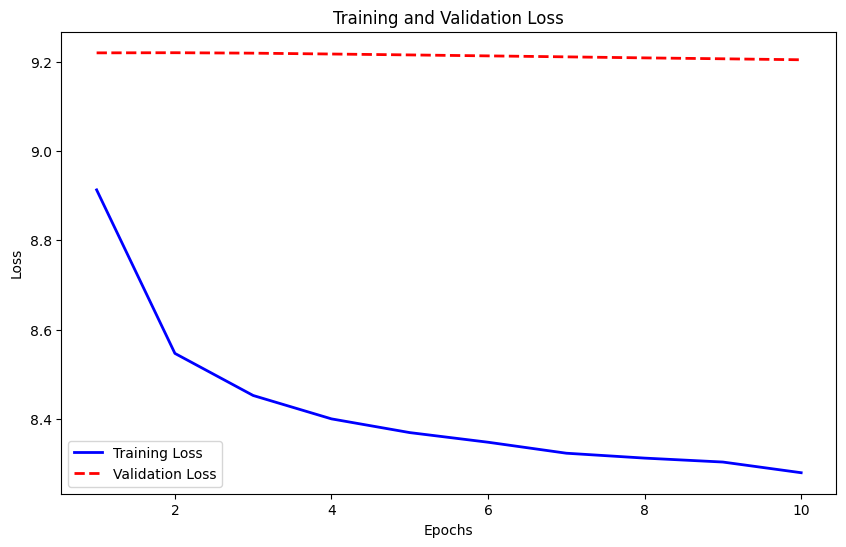

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np  # 确保导入了 numpy
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from model import LanguageModel  

# 创建 LanguageModel 实例
language_model = LanguageModel(vocab_size=10000, max_seq_length=20, data_file='train_data.json')

# 设置学习率调度和早停回调
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr * (epoch + 1) / 5)  # Warm-Up 阶段增加学习率
    else:
        return float(lr * np.exp(-0.1))  # 训练后期衰减学习率

# 创建训练历史回调
lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True, verbose=1)

# 开始训练，不保存模型，只是用来展示损失
history = language_model.model.fit(
    language_model.question_sequences,
    language_model.answer_sequences,
    epochs=10,  # 训练10个epoch以展示损失图
    batch_size=64,
    verbose=1,
    validation_split=0.1,  # 使用10%的数据作为验证集
    callbacks=[lr_scheduler, early_stopping]
)

# 在训练结束后绘制图表
def plot_loss(history):
    """
    使用训练历史绘制损失图。
    """
    # 获取训练和验证损失
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])  # 使用 .get() 避免没有验证损失时出错
    epochs = range(1, len(train_loss) + 1)

    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-', linewidth=2)
    if val_loss:  # 如果有验证损失，则绘制
        plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 绘制损失图表
plot_loss(history)
